<a href="https://colab.research.google.com/github/davidbradway/ENGAGEDurham/blob/master/Durham_topicmodeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic Modeling for Everybody with Google Colab

**Super simple topic modeling using the Latent Dirichlet Allocation (LDA) algorithm, Top Topics, Common Words, LDA Visualization, Sentiment Analysis and WordCloud.**

This Google Colab Notebook makes topic modeling accessible to everybody. Textual data can be loaded from a Google Sheet and topics derived from LDA can be generated. Only simple form entry is required to set:

* the name of the google sheet
* the number of topics to be generated
* the number of top words and documents that must be printed out for each topic


In [0]:
# Importing modules
import pandas as pd
import numpy as np
import re
import string
import random
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning)

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

!pip install --upgrade -q pyLDAvis
import pyLDAvis

!pip install nltk==3.3
import nltk
nltk.download('twitter_samples')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import twitter_samples, stopwords
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk import FreqDist, classify, NaiveBayesClassifier

[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
#@title Install gspread, authenticate and load data from a Google Sheet
!pip install --upgrade -q gspread

from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

googlesheet_filename = 'mydata' #@param {type:"string"}
data_rows_to_preview =  8#@param {type:"integer"}

gc = gspread.authorize(GoogleCredentials.get_application_default())
worksheet = gc.open(googlesheet_filename).sheet1

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()

#You can get data into Colab in other ways... Haven't tried MS Excel yet.
# Read data into papers
#import os
#os.chdir('..')
#dataset_df = pd.read_csv('./data/NIPS Papers/papers.csv')
#filename = 'https://gist.githubusercontent.com/davidbradway/4bafc493213b77a02f03734cac8def97/raw/8589dd36e5559de878ec3d9ba142eacfdd3658a0/used_leaf.csv'
#dataset_df = pd.read_csv(filename);

In [0]:
# xlrd is needed to load excel files
!pip install xlrd

# One way to load the data
column_names = ["sepal_length", "sepal_width" , "petal_length", "petal_width", "variety"]

iris_excel_path = "https://github.com/stratascratch/stratascratch.github.io/raw/master/assets/iris.xlsx"

setosa_data = pd.read_excel(iris_excel_path, "Setosa", header=None, names=column_names) # Setosa is the sheet name
versi_data  = pd.read_excel(iris_excel_path, 1, header=None, names=column_names) # 1 is the index of the second sheet
virgi_data  = pd.read_excel(iris_excel_path, 2, header=None, names=column_names)

# we need to reset the index to have nice linear indices from 0, 1 to 150
# reset_index() adds a new column called "index" which we drop (explained later)
iris = pd.concat([setosa_data, versi_data, virgi_data]).reset_index().drop("index", axis=1)

iris.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [0]:
#@title Load, Clean, and Preview data

# convert the 2nd column values to a list
documents = []
for row in rows[1:]:
  documents.append(row[1])  
#print(documents)

# Convert to a DataFrame and render.
dataset_df = pd.DataFrame.from_records(rows)

# Move Row 0 Header to Column Names
# This calls the first row for the header
new_header = dataset_df.iloc[0] 
# take the rest of your data minus the header row
dataset_df = dataset_df[1:] 
# set the header row as the df header
dataset_df.columns = new_header
# Remove the columns id
dataset_df = dataset_df.drop(columns=['id'], axis=1)

# Remove punctuation
dataset_df['paper_text_processed'] = dataset_df['text'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
dataset_df['paper_text_processed'] = dataset_df['paper_text_processed'].map(lambda x: x.lower())
# Print out the first rows of papers
dataset_df['paper_text_processed'].head(n=data_rows_to_preview)


1    the planning department just last week approve...
2    airports are required to suspend a flight befo...
3    there are not enough good jobs for young peopl...
4    now the town which has no binding power has bo...
5    further she raised questions about whether the...
6    the political committees control the elections...
7    there are too few black owned businesses downt...
8    gentrification is driving people from their ne...
Name: paper_text_processed, dtype: object



---



---



In [0]:
#@title \# of Topics, Words, Comments

no_topics = 4 #@param {type:"integer"}

no_words = 3 #@param {type:"integer"}

no_top_words = 6 #@param {type:"integer"}

no_top_comments = 2 #@param {type:"integer"}

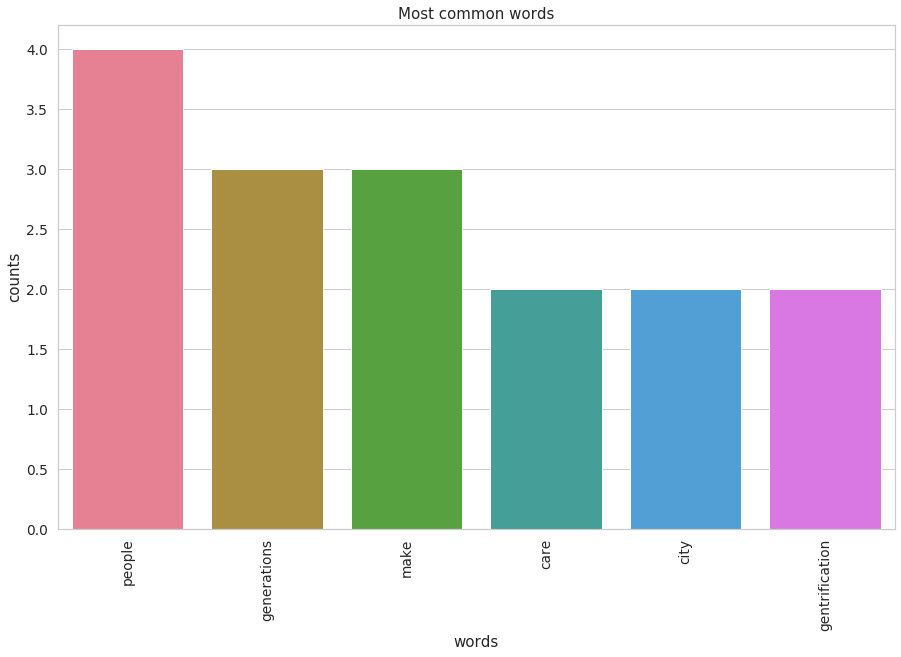

In [0]:
#@title Show Most Common Words

# Helper function
def plot_most_common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:no_top_words]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='Most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
# Fit and transform the processed titles
my_documents  = list(dataset_df['paper_text_processed'])
count_data = count_vectorizer.fit_transform(my_documents)
tf_feature_names = count_vectorizer.get_feature_names()
# Visualise most common words
plot_most_common_words(count_data, count_vectorizer)

In [0]:
#@title Print Topics and Words
# Helper function
def display_topics(H, W, feature_names, documents, no_words, no_top_comments):
    for topic_idx, topic in enumerate(H):
        print("%d: " % (topic_idx), end="")
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_comments]
        for doc_index in top_doc_indices:
            print("   ",documents[doc_index])

# Create and fit the LDA model
lda_model = LatentDirichletAllocation(n_components=no_topics, n_jobs=-1, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(count_data)
lda_W = lda_model.transform(tf)
lda_H = lda_model.components_

# Print the topics found by the LDA model
print("Topics found via LDA:")
display_topics(lda_H, lda_W, tf_feature_names, my_documents, no_words, no_top_comments)

Topics found via LDA:
0: generations care people
    the political committees control the elections process and the electors are paid by the state and by the candidates there are few exceptions for instance retired judges are not allowed to become the electors; they instead serve as retired judges and can only vote as retired judges
    airports are required to suspend a flight before it begins and then return to full operation within five minutes
1: city care make
    the planning department just last week approved allowing the city to make a grant and it's expected to be available this spring
    further she raised questions about whether the congresswoman should support a human rights ordinance for dallas county it also clarified that both sides support health care for the city's lgbt community
2: people generations gentrification
    gentrification is driving people from their neighborhoods his family has lived in the neighborhood for generations his grandfather lived there for gen

In [0]:
#@title LDA Topic Visualization Tool


In [0]:
%%time
LDAvis_prepared = pyLDAvis.sklearn.prepare(lda_model, tf, tf_vectorizer)

CPU times: user 162 ms, sys: 7.77 ms, total: 170 ms
Wall time: 1.85 s


In [0]:
pyLDAvis.display(LDAvis_prepared)

# Sentiment Analysis with NLTK

In [0]:
def remove_noise(tweet_tokens, stop_words = ()):

    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        token = re.sub("(@[A-Za-z0-9_]+)","", token)
        token = re.sub("([\(\):]+)","", token)

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

def get_all_words(cleaned_tokens_list):
    for tokens in cleaned_tokens_list:
        for token in tokens:
            yield token

def get_tweets_for_model(cleaned_tokens_list):
    for tweet_tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tweet_tokens)

In [0]:
#@title Train Sentiment Model on Tweets
positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')
text = twitter_samples.strings('tweets.20150430-223406.json')
tweet_tokens = twitter_samples.tokenized('positive_tweets.json')[0]

stop_words = stopwords.words('english')

positive_tweet_tokens = twitter_samples.tokenized('positive_tweets.json')
positive_cleaned_tokens_list = []
for tokens in positive_tweet_tokens:
    positive_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

negative_tweet_tokens = twitter_samples.tokenized('negative_tweets.json')
negative_cleaned_tokens_list = []
for tokens in negative_tweet_tokens:
    negative_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

all_pos_words = get_all_words(positive_cleaned_tokens_list)

freq_dist_pos = FreqDist(all_pos_words)
#print("Most common words in positive word training set: ", freq_dist_pos.most_common(10))

positive_tokens_for_model = get_tweets_for_model(positive_cleaned_tokens_list)
negative_tokens_for_model = get_tweets_for_model(negative_cleaned_tokens_list)

positive_dataset = [(tweet_dict, "Positive")
                      for tweet_dict in positive_tokens_for_model]
negative_dataset = [(tweet_dict, "Negative")
                      for tweet_dict in negative_tokens_for_model]

dataset = positive_dataset + negative_dataset
random.shuffle(dataset)

train_data = dataset[:7000]
test_data = dataset[7000:]

classifier = NaiveBayesClassifier.train(train_data)
print("Accuracy is:", classify.accuracy(classifier, test_data))
#print(classifier.show_most_informative_features(10))

Accuracy is: 0.7453333333333333


In [0]:
comment_list = list(papers['paper_text_processed'])
tokens_list = []
for comment in comment_list:
    tokens_list.append(word_tokenize(comment))

cleaned_tokens_list = []
for token in tokens_list:
    cleaned_tokens_list.append(remove_noise(token, stop_words))

flatten = lambda l: [item for sublist in l for item in sublist]
#print(cleaned_tokens_list)
#print(flatten(cleaned_tokens_list))

In [0]:
#@title Sentiment of Each Comment
sentiments = []
for i, custom_comment in enumerate(comment_list):
    custom_tokens = cleaned_tokens_list[i]
    sentiment = classifier.classify(dict([token, True] for token in custom_tokens))
    sentiments.append(sentiment)
    print(sentiment, custom_comment)

Positive the planning department just last week approved allowing the city to make a grant and it's expected to be available this spring
Negative airports are required to suspend a flight before it begins and then return to full operation within five minutes
Negative there are not enough good jobs for young people and this will only get worse" the reality is that low wage and poor wage jobs do exist it is the non-union wage jobs that need to be significantly expanded to meet our growing workforce needs
Negative now the town which has no binding power has bowed to the strong-arm of duke energy which sought a gift that was higher than any of its other "generations" of contributions
Positive further she raised questions about whether the congresswoman should support a human rights ordinance for dallas county it also clarified that both sides support health care for the city's lgbt community
Positive the political committees control the elections process and the electors are paid by the st

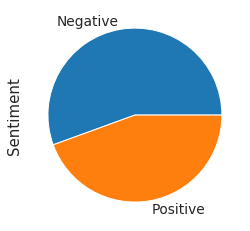

In [0]:
#@title Pie Chart Breakdown of Sentiment
test = pd.Series(sentiments, name="Sentiment").astype("category")
groups = test.groupby([test]).agg(len)
ax=groups.plot(kind='pie')
plt.show()

# Word Cloud Qualitative Visualization

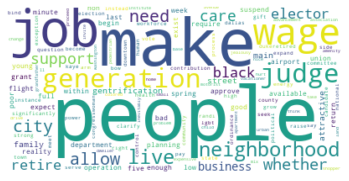

In [0]:
from wordcloud import WordCloud
# Join all the cleaned comments together.
long_string = ','.join(flatten(cleaned_tokens_list))
# Generate a word cloud image
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue').generate(long_string)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()